## Bootstrap Slope Confidence Interval Examples
Class 023

In [1]:
## import statements
# These lines load the tests. 
from gofer.ok import check
import numpy as np
from datascience import *
import pandas as pd
import matplotlib
from matplotlib import patches
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
plt.style.use('ggplot')
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
# Fix for datascience collections Iterable
import collections as collections
import collections.abc as abc
collections.Iterable = abc.Iterable

In [25]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz)) / np.std(xyz)


def correlation(t, label_x, label_y):
    return np.mean(
        standard_units(t.column(label_x)) * standard_units(t.column(label_y))
    )


# Regression
def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r * np.std(t.column(label_y)) / np.std(t.column(label_x))


def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y) * np.mean(
        t.column(label_x)
    )


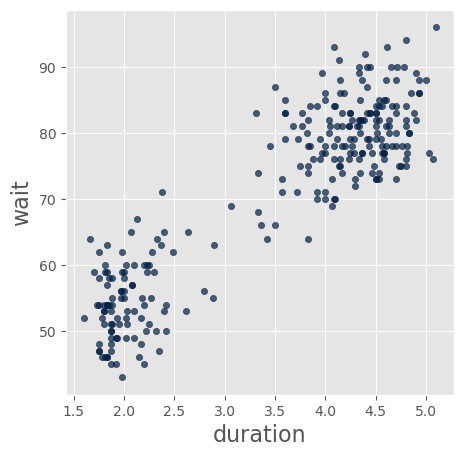

In [3]:
faithful = Table.read_table("../Lab08/faithful-new.csv")
faithful.scatter('duration','wait')

#### Slope
***

slope of the regression line $= r \cdot
\frac{SD_y}{SD_x}$<br>
intercept of the regression line $=
\bar{y} - slope \cdot \bar{x}$<br><br>
***
equation of the regression line:<br> $ \hat{y} =$
 slope $\cdot x $+ intercept<br>
error in fit:<br> error $ =  y - \hat{y} = y - $slope $\cdot x $+ intercept<br>

***

In [5]:
duration_mean = np.mean(faithful["duration"])
duration_std = np.std(faithful.column("duration"))
wait_mean = np.mean(faithful.column("wait"))
wait_std = np.std(faithful.column("wait"))

faithful_standard = Table().with_columns(
    "duration (standard units)",
    (faithful.column("duration") - duration_mean) / duration_std,
    "wait (standard units)",
    (faithful.column("wait") - wait_mean) / wait_std,
)

In [6]:
r = np.mean(faithful_standard["duration (standard units)"] * faithful_standard["wait (standard units)"])
r

0.90081116832181318

In [7]:
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


In [8]:
slope = r * wait_std / duration_std
print("Slope; ",slope)
print("For every 1 minute longer eruption duration we wait about ",round(slope,1)," minutes longer")

Slope;  10.7296413951
For every 1 minute longer eruption duration we wait about  10.7  minutes longer


In [9]:
intercept = wait_mean - slope * duration_mean
intercept

33.474397022753344

In [10]:
# error = y - ypredict
tbl = faithful
error_list = []
for i in np.arange(tbl.num_rows):
    predicted_y = tbl.row(i)[0] * slope + intercept
    error = tbl.row(i)[1] - predicted_y
    error_list.append(error)

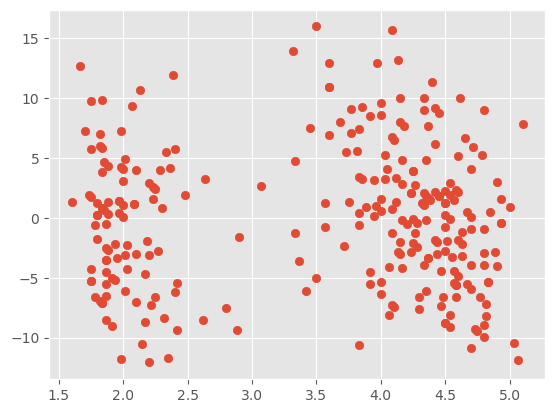

In [26]:
plt.scatter(faithful['duration'], error_list)
plt.show()

In [12]:
def fit_line(tbl):
    # x data is in column 0 and y data is in column 1
    # Your code may need more than 1 line below here.
    xdata, ydata = tbl.column(0), tbl.column(1)

    def mse_f(slope, intercept):
        fitted = slope * xdata + intercept
        return np.mean((ydata - fitted) ** 2)

    values = minimize(mse_f)
    slope = values[0]
    intercept = values[1]
    return make_array(slope, intercept)

### DIGRESSION: Why did we use nested functions above?
This has to do with the scope of the varaiables. The function mse_f() was able to use the variables xdata and ydata without have to explicitly pass them into the function because they were defined in the enclosing scope of the function fit_line().

Below is an simpler example:

In [31]:
ages = Table().with_columns('Name', make_array('Bob', 'Kisha'), 'Age', make_array(21, 19))
ages

Name,Age
Bob,21
Kisha,19


In [34]:
def add_to_ages(years):
    new_ages = ages.column('Age') + years
    print(new_ages)
    
add_to_ages(5)

[26 24]


In [35]:
print(new_ages)

NameError: name 'new_ages' is not defined

The function add_to_ages can use the table "ages" because it is in the enclosing scope. But the variable "new_ages" is not defined ouside of the function add_to_ages(), so it prints inside the function but trying to print it outside of the function creates an error.

#### End Digression

In [13]:
fit_line(faithful)

array([ 10.72964138,  33.47439706])

In [14]:
fit_line(faithful.sample())

array([ 10.99469855,  32.58503311])

### Bootstrap 95% Confidence Interval

95% confidence interval for the predicted additional wait for 1 minute longer duration of Old Fathful : [10.1376, 10.7296, 11.3407] minutes


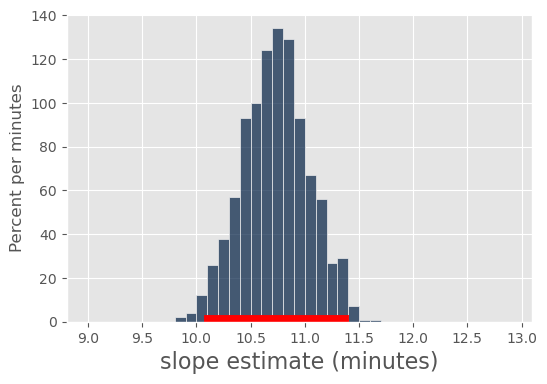

In [15]:
bootstrap_slope = make_array()
for i in np.arange(1000):
    bootstrap_slope = np.append(bootstrap_slope, fit_line(faithful.sample())[0]) # Sample without replacement

lower_end = percentile(2.5,bootstrap_slope)
upper_end = percentile(97.5,bootstrap_slope)
Table().with_column("slope estimate", bootstrap_slope).hist(bins=np.arange(9, 13, .1), unit="minutes")
print("95% confidence interval for the predicted additional wait for 1 minute longer duration of Old Fathful : [{:g}, {:g}, {:g}] minutes".format(lower_end, slope, upper_end))
plt.plot([lower_end, upper_end], [0, 0], color='red', lw=10)
plt.show()

***
### 2018 Philadelphia Primary voter registration
Voter registration by Ward. Look at the average size of a Ward

In [16]:
url = 'qualified_voter_listing_2018_primary_by_ward.csv'
url='https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+qualified_voter_listing_2018_primary_by_ward&filename=qualified_voter_listing_2018_primary_by_ward&format=csv&skipfields=cartodb_id,the_geom,the_geom_webmercator'
vote = Table().read_table(url).where('ward',are.containing("WD")) # Elimate row with with totals only wards
vote.sort('total',descending=True)

ward,dem,rep,other_party,total,white,black,hispanic,other_race,male,female,unknown_sex
WD05,23018,4564,6717,34299,8697,2143,787,1628,12700,12421,9178
WD21,20507,6708,5098,32313,11722,1923,453,666,11334,13046,7933
WD08,20574,4589,6005,31168,8437,987,494,996,10582,12850,7736
WD40,24820,1412,2472,28704,1303,14859,246,1137,8691,11363,8650
WD58,15914,8484,3997,28395,11813,955,905,1603,9151,10530,8714
WD66,15026,9422,2651,27099,13320,1110,872,523,9115,10512,7472
WD34,22629,984,1994,25607,1099,13178,224,465,7547,10777,7283
WD39,18537,3814,2899,25250,10599,1311,696,1536,8667,9741,6842
WD56,14732,4536,2946,22214,7708,1868,1411,1146,7422,8949,5843
WD36,18122,1382,2299,21803,2448,8853,365,811,7590,8641,5572


In [17]:
np.average(vote['total'])

15688.181818181818

In [18]:
def one_bootstrap_mean():
    resample = vote.sample()
    return np.mean(resample.column('total'))

In [19]:
one_bootstrap_mean()

16526.727272727272

In [20]:
percentile(50, vote.column('total')) # median

14268

In [21]:
vote.sample().sort('total',descending=True)

ward,dem,rep,other_party,total,white,black,hispanic,other_race,male,female,unknown_sex
WD05,23018,4564,6717,34299,8697,2143,787,1628,12700,12421,9178
WD05,23018,4564,6717,34299,8697,2143,787,1628,12700,12421,9178
WD21,20507,6708,5098,32313,11722,1923,453,666,11334,13046,7933
WD08,20574,4589,6005,31168,8437,987,494,996,10582,12850,7736
WD08,20574,4589,6005,31168,8437,987,494,996,10582,12850,7736
WD58,15914,8484,3997,28395,11813,955,905,1603,9151,10530,8714
WD58,15914,8484,3997,28395,11813,955,905,1603,9151,10530,8714
WD39,18537,3814,2899,25250,10599,1311,696,1536,8667,9741,6842
WD56,14732,4536,2946,22214,7708,1868,1411,1146,7422,8949,5843
WD36,18122,1382,2299,21803,2448,8853,365,811,7590,8641,5572


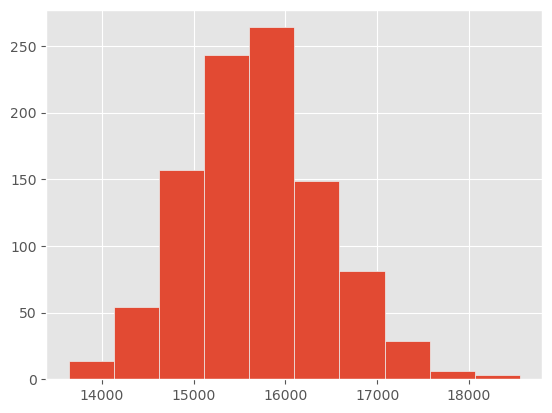

In [22]:
total_mean = []
for i in np.arange(1000):
    total_mean.append(one_bootstrap_mean())
plt.hist(total_mean)
plt.show()

In [23]:
left = percentile(2.5, total_mean)
right = percentile(97.5, total_mean)

make_array(left, right)

array([ 14302.09090909,  17194.03030303])

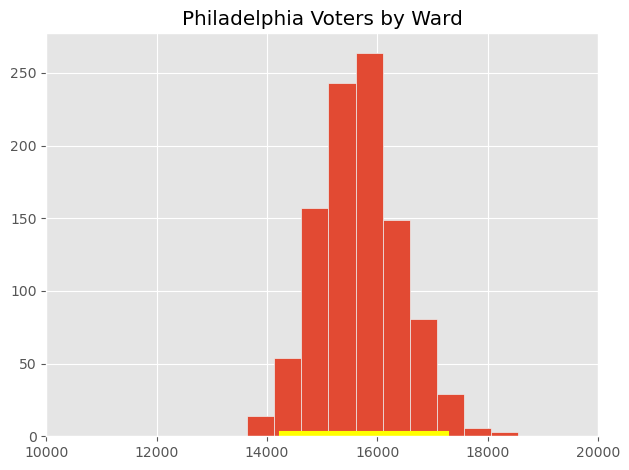

In [24]:
plt.hist(total_mean)
plt.plot([left, right], [0, 0], color='yellow', lw=8)
plt.title("Philadelphia Voters by Ward")
plt.xlim(10000,20000)
plt.tight_layout()
plt.savefig('bootstrap_CI.png')